# 2. ALOS-2/PALSAR-2観測によるダム水位監視

## 本演習教材の学習目標

- スペックルノイズを低減する前処理 (オプション）
- 八ッ場ダムのSAR衛星観測データの可視化
- ダム操作の変化検出

はじめに本演習で利用するパッケージをインストールします。

In [ ]:
!conda install -c conda-forge numpy matplotlib scikit-image rasterio -y
!pip install opencv-python

## 2.1. ALOS-2 データの準備

### 2.1.1. ALOS-2のデータをダウンロードする

In [1]:
#!curl --output 2-Yamba.zip "https://owncloud.glodal-inc.net/owncloud/index.php/s/fORunC9aDo38G5s/download"

import shutil, os
shutil.unpack_archive("2-Yamba.zip", ".")
os.chdir('Yamba')
os.listdir()

['IMG-HH-ALOS2281962880-190813-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294382880-191105-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2299040720-191206-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2308650720-200209-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2310942880-200225-UBSR2.1GUD.tif']

### 2.1.2 前処理（スペックルノイズ低減とDN変換）

#### Leeフィルタによるスペックルノイズ低減

Leeフィルターは、SAR（合成開口レーダー）画像のスペックルノイズを低減するために使用される技術です。スペックルノイズは、SAR観測に自然に発生する粒状のランダムなノイズで、画像解析に影響する場合が多くあります。

以下のコードは、合成開口レーダー（SAR）画像のスペックルノイズを低減するために一般的に使用される**Leeフィルタ**を実装しています。このフィルタは、（`window_size`で定義されるサイズの）スライディングウィンドウを使用して画像内の各ピクセルを処理することで動作します。各窓について、局所的な平均と分散を計算し、画素にどの程度の平滑化を適用するかを制御する減衰係数(damping factor)を決定します。

参考文献: 
- [SAR Image Despeckling Using Refined Lee Filter](https://ieeexplore.ieee.org/document/7334965)
- [Digital Image Enhancement and Noise Filtering by Use of Local Statistics](https://ieeexplore.ieee.org/document/4766994?rsource=https:%2F%2Flinks.esri.com%2FNoiseFilteringUsingLocalStats)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage import img_as_float
from scipy.ndimage import uniform_filter


import numpy as np
from scipy.ndimage import uniform_filter

# リー・フィルター関数を定義する


def lee_filter(image, size):
    """
    Applies the Lee filter to an input image to reduce speckle noise.
    
    Parameters:
        image (numpy.ndarray): The input image to be filtered.
        size (int or tuple): The size of the local neighborhood (e.g., window size).
        
    Returns:
        numpy.ndarray: The filtered image.
    """
    # Ensure the input image is a floating-point array for precision
    image = image.astype(np.float32)
    
    # Calculate local mean and squared mean using uniform filter
    local_mean = uniform_filter(image, size=size)
    local_mean_sqr = uniform_filter(image**2, size=size)
    
    # Calculate local variance
    local_variance = local_mean_sqr - local_mean**2
    
    # Estimate noise variance (overall variance of the image)
    overall_variance = np.mean(local_variance)
    
    # Compute the filter weight
    weight = local_variance / (local_variance + overall_variance)
    weight = np.clip(weight, 0, 1)  # Ensure weight is in a valid range
    
    # Apply the Lee filter formula
    filtered_image = local_mean + weight * (image - local_mean)
    
    return filtered_image


#### DN値から後方散乱係数への変換

複数の観測データを用いる時系列分析等においては画素値を後方散乱係数に変換する必要があります。詳細は[校正・検証](https://www.eorc.jaxa.jp/ALOS/jp/alos-2/a2_calval_j.htm)

$$ \sigma^0_{Q16} = 10 log_{10}<DN^2> + CF$$

ただし、<>はノイズ低減のための平均化を表し、CFには-83.0 dBを用いる。以下にコーディング例を示します。

In [5]:
def calibrate_image(image):
    image = img_as_float(image)
    calibrated_image = (10 * np.log10(image**2)) - 83
    return calibrated_image

In [33]:
image_files

['export.tif',
 'IMG-HH-ALOS2281962880-190813-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2294382880-191105-UBSR2.1GUD.tif',
 'IMG-HH-ALOS2299040720-191206-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2308650720-200209-UBSR2.1GUA.tif',
 'IMG-HH-ALOS2310942880-200225-UBSR2.1GUD.tif']

##### 各画像データの前処理を実行

前節で定義した関数を各画像データに処理し、結果を表示します。

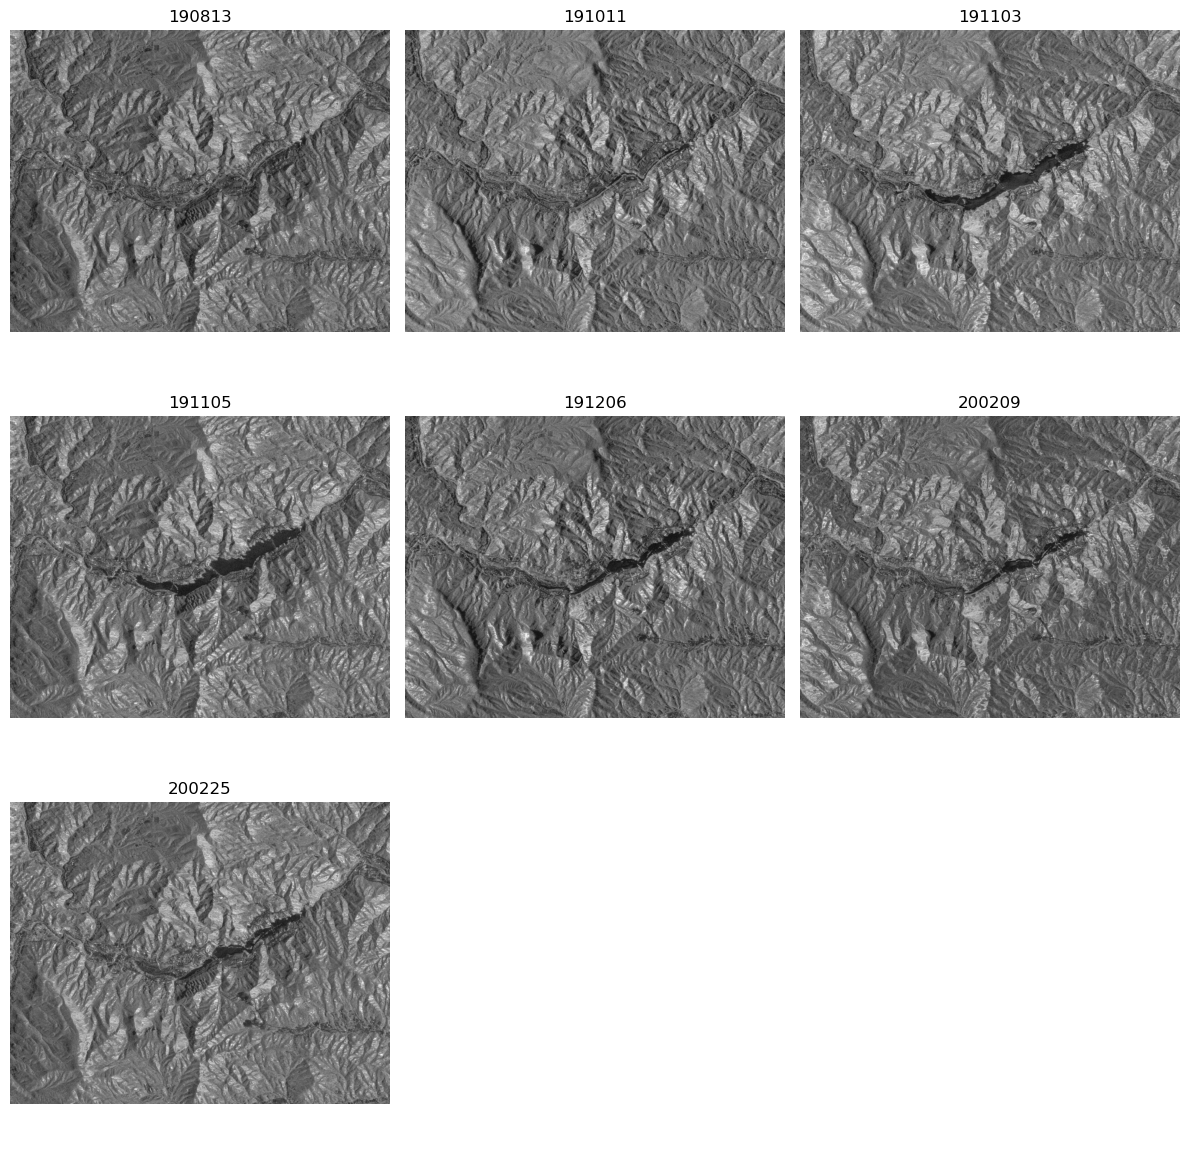

In [7]:
import os, math, re

# File handling
image_files = [f for f in os.listdir() if f.endswith('.tif')]
preprocessed_images = []

for file in image_files:
    with rasterio.open(file) as src:
        if src.count >= 1:
            img = src.read(1)  # Read the first band
        else:
            raise ValueError(f"File {file} does not contain a valid band.")
    
    # Step 1: Apply speckle filter
    filtered_img = lee_filter(img, size=5)
    
    # Step 2: Convert to backscatter coefficients
    calibrated_img = calibrate_image(filtered_img)
    preprocessed_images.append(calibrated_img)

# Define number of rows and compute columns dynamically
nrows = 3
ncols = math.ceil(len(preprocessed_images) / nrows)

# Create subplots grid
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

# Flatten axes to simplify indexing (even if nrows > 1)
axes = axes.flatten()

# Plot each image
for i, image in enumerate(preprocessed_images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(re.search(r"-(\d{6})-", image_files[i]).group(1))

# Turn off unused axes if there are any
for ax in axes[len(preprocessed_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


後方散乱係数が小さい領域（中央あたりの暗い領域）が水域を表します。10月11日から11月3日にかけて水域が出現しますが、これは[2019年台風19号による豪雨のため湛水した様子](https://ja.wikipedia.org/wiki/%E5%85%AB%E3%83%83%E5%A0%B4%E3%83%80%E3%83%A0#%E4%BB%A4%E5%92%8C%E5%85%83%E5%B9%B4%E6%9D%B1%E6%97%A5%E6%9C%AC%E5%8F%B0%E9%A2%A8)を表しています。その後も数ヶ月にわたって水面が見えることから時間をかけて放流した様子がうかがえます。

## 2.2. カラー合成画像による変化の分析

観測日が異なるSAR衛星データをカラー合成することで変化を分析できます。ここでは赤色チャンネルに2020年10月11日（台風前）、緑色・青色チャンネルに2019年11月3日（台風後）を割り当てる例を示します。

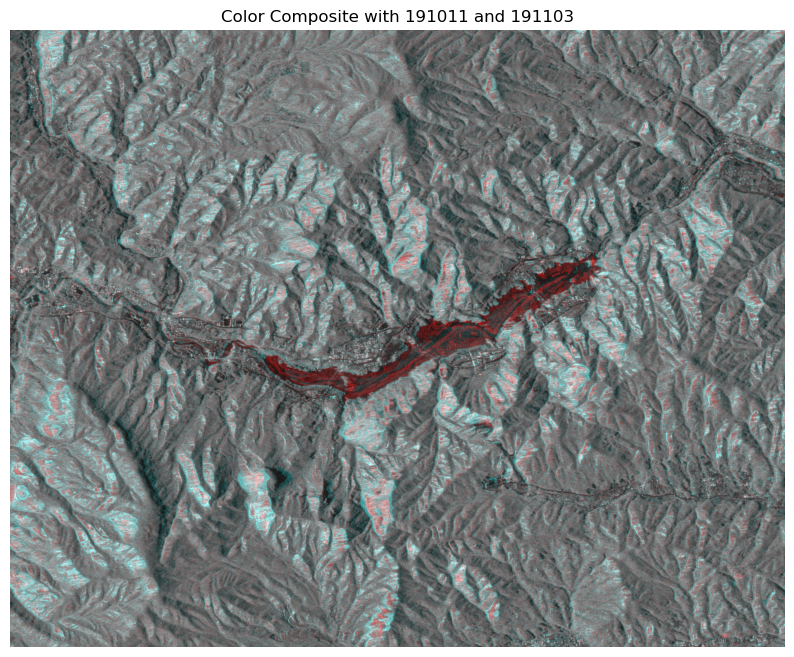

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

red   = preprocessed_images[image_files.index('IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif')]
green = preprocessed_images[image_files.index('IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif')]
blue  = preprocessed_images[image_files.index('IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif')]

# バンドをRGB画像配列に積み上げる
rgb_image = np.stack([red, green, blue], axis=-1)

# より見やすくするためにバンドを正規化する（オプション）
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())  # Normalize to [0, 1]

# RGBコンポジットを表示
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Color Composite with 191011 and 191103")
plt.axis("off")
plt.show()

赤色で表れる領域が10月12日の豪雨によって冠水した領域を表します。また黒い領域は10月11日時点でも水面であることを表しています。

#### （オプショナル）RGB 合成画像をGeoTiffに保存する
合成画像をGIS等で表示したい場合には、入力バンドと同じ空間情報（座標参照系やジオトランスフォームなど）を持つGeoTIFFとして保存します。以下のコードでは、入力バンドの1つ（例えば赤バンド）のCRSと変換を保持したまま、RGB合成を保存します。

In [44]:
meta_tif = 'IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif'
outfile = "export.tif"

# メタデータを取得するには、赤いバンドをもう一度開きます
with rasterio.open(meta_tif) as src:
    # 3つのバンド（RGB）とfloat32データ型に対応するようにメタデータを更新。
    rgb_meta = src.meta.copy()
    rgb_meta.update({
        "count": 3,           # RGB 3バンド
        "dtype": "float32",   # 正規化画像のデータ型
        "driver": "GTiff",    # 出力形式が GeoTIFF であることを確認する。
        "compress": "Deflate" # ファイルサイズが膨れやすいので圧縮オプションを推奨
    })

    # RGB画像をGeoTIFFとして書き込む
    with rasterio.open(outfile, "w", **rgb_meta) as dst:
        # 各チャンネルを別々のバンドに書き込む
        dst.write((rgb_image[:, :, 0] * 255).astype("uint8"), 1)  # 赤チャンネル
        dst.write((rgb_image[:, :, 1] * 255).astype("uint8"), 2)  # 緑チャンネル
        dst.write((rgb_image[:, :, 2] * 255).astype("uint8"), 3)  # 青チャンネル

print(f"RGB composite image saved to {outfile}")

RGB composite image saved to export.tif


## 2.3. ダムの水域変化の検知

２時期の差分画像を計算することで有意な変化を検出できます。本節では10月11日、11月3日を例にデータ解析を行います。
- 台風19号は2019年10月12日に日本を直撃したため、台風前の画像には2019年10月11日の画像を使用する。
- 台風後の画像には、2019年11月3日の画像を使用します。これは、台風後、最初に入手可能な画像である。

まず観測データを画像に可視化して時期別に比較します。

C:\Users\herom\AppData\Local\Temp\ipykernel_36852\491692531.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


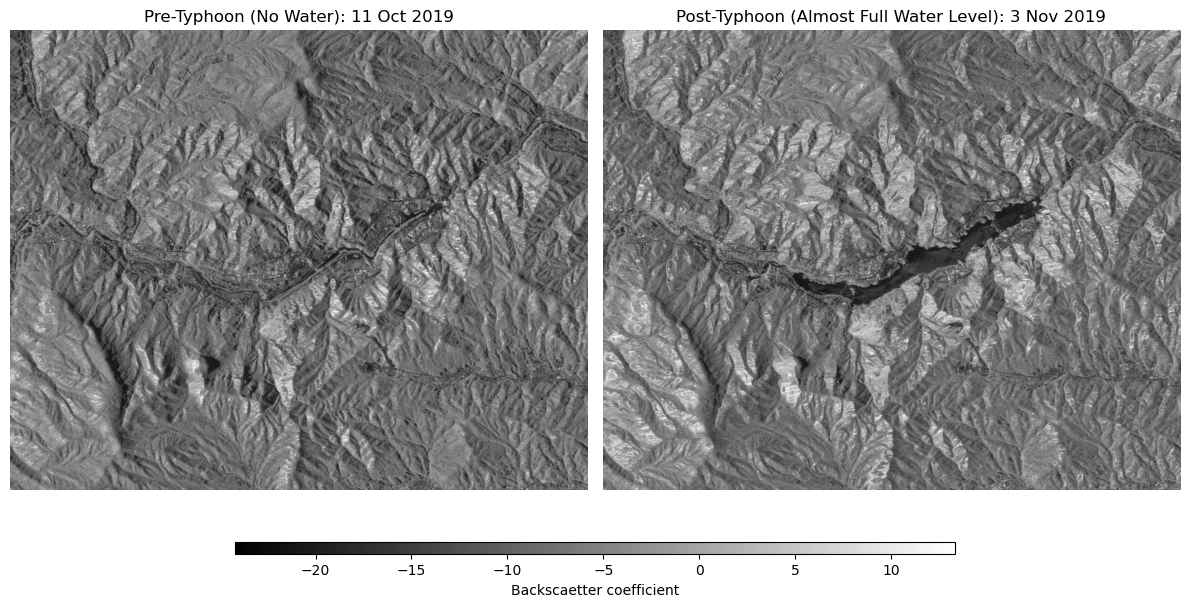

In [11]:
import rasterio
import matplotlib.pyplot as plt

pre_typhoon   = preprocessed_images[image_files.index('IMG-HH-ALOS2290760720-191011-UBSR2.1GUA.tif')]
post_typhoon  = preprocessed_images[image_files.index('IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif')]

# Set up the figure for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot each image and store one of them for the color bar
im = axes[0].imshow(pre_typhoon, cmap='gray')  # Assign to `im` for color bar reference
axes[0].set_title("Pre-Typhoon (No Water): 11 Oct 2019")
axes[0].axis("off")

axes[1].imshow(post_typhoon, cmap='gray')
axes[1].set_title("Post-Typhoon (Almost Full Water Level): 3 Nov 2019")
axes[1].axis("off")

# Add a color bar below all images without overlapping
cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.02])  # Centered below all images
fig.colorbar(im, cax=cbar_ax, orientation='horizontal').set_label('Backscaetter coefficient')

plt.tight_layout()
plt.show()

- 台風前： 2019年10月11日、ダムは全面開通（2019年10月完成、2020年4月1日正式開通）していない。そのため、画像ではダム域の小さな川しか確認できない。
- 台風後： 2019年11月3日、ダムは正式に開通していないにもかかわらず、ダムの水位は非常に高くなった。これは、2019年10月12日に台風ハギビスが日本を直撃し、大雨が降って八ッ場ダムの水位が急上昇した。

### 2.3.1. ２時期の差分を計算する

以下のセルで10月12日～11月3日の変化を検出するための差分画像を計算します。

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

diff_img_1012_1103 = post_typhoon - pre_typhoon

差分画像を表示してみます。台風で冠水した領域が浮き上がります。

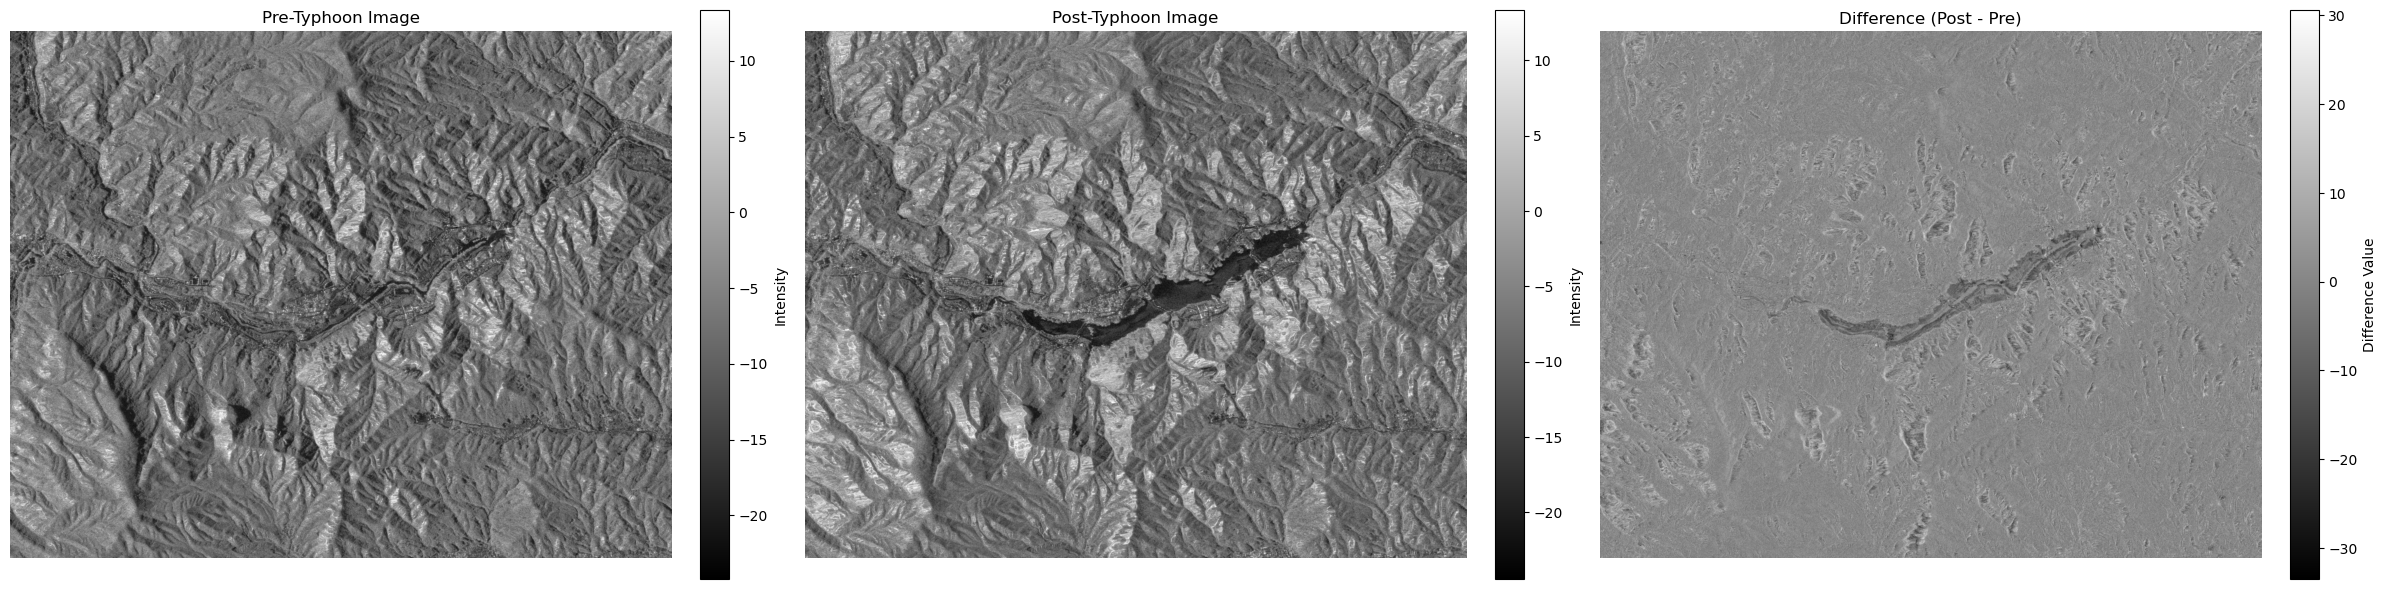

In [15]:
import matplotlib.pyplot as plt

# 結果を凡例で視覚化する
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 台風前の画像をプロットする。
img0 = axes[0].imshow(pre_typhoon, cmap='gray')
axes[0].set_title("Pre-Typhoon Image")
axes[0].axis("off")
cbar0 = fig.colorbar(img0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar0.set_label("Intensity")

# 台風後の画像をプロットする。
img1 = axes[1].imshow(post_typhoon, cmap='gray')
axes[1].set_title("Post-Typhoon Image")
axes[1].axis("off")
cbar1 = fig.colorbar(img1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label("Intensity")

# 差分画像をプロット
img2 = axes[2].imshow(diff_img_1012_1103, cmap='gray')
axes[2].set_title("Difference (Post - Pre)")
axes[2].axis("off")
cbar2 = fig.colorbar(img2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label("Difference Value")

# レイアウトを調整し、プロットを表示する
plt.tight_layout()
plt.show()

差分画像のヒストグラムでは、画素値の分布が正規分布であることがわかります。したがって、両側を有意な変化であるとみなすことができそうです。

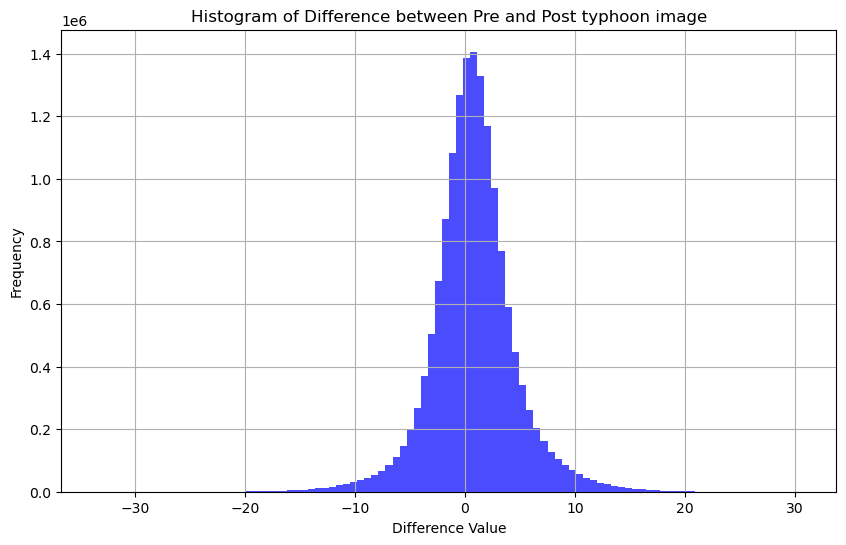

In [17]:
# 差のヒストグラムをプロットする
plt.figure(figsize=(10, 6))
plt.hist(diff_img_1012_1103.ravel(), bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Difference between Pre and Post typhoon image")
plt.xlabel("Difference Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### 2.3.3. 差分画像から有意な変化を検出する

本節では画素値分布の両側2.5%（$\mu \pm 2\sigma$）を有意な変化とみなして、水域変化の領域を検出する手順を示します。

##### 平均と標準偏差による閾値の計算

差分画像の画素値平均 (`mean_diff`) と標準偏差 (`std_diff`) を計算する。

以下のセルでは：
- μ±2σで下限値と上限値を設定する。
- `[lower_bound, upper_bound]`の範囲内のピクセルは 「変化なし 」とみなされ、この範囲外[`< lower_bound`または `> upper_bound`]のピクセルは 「変化あり 」とみなされる。
- この方法は、正規分布の仮定に従い、±2σの範囲内のほとんどのピクセルは変化なしを表すと仮定する。

注：`diff_img_1012_1103`（前節の出力）は、台風前後の画像のピクセルごとの差を表す。

In [19]:
# 平均と標準偏差を計算する
mean_diff = np.mean(diff_img_1012_1103)
std_diff = np.std(diff_img_1012_1103)

# μ±2σで閾値を定義する
lower_bound = mean_diff - 2 * std_diff
upper_bound = mean_diff + 2 * std_diff

##### 閾値を適用して、変化領域とそれ以外に分類する。

各ピクセルに 「変化あり 」か 「変化なし 」かのラベルを付けたバイナリマップ（`changed_area1`）を作成する。

In [21]:
# μ±2σの閾値を適用する
changed_area = ((diff_img_1012_1103 < lower_bound) | (diff_img_1012_1103 > upper_bound)).astype(np.uint8)  # 1 for changed, 0 for no-change

##### 分類結果の可視化

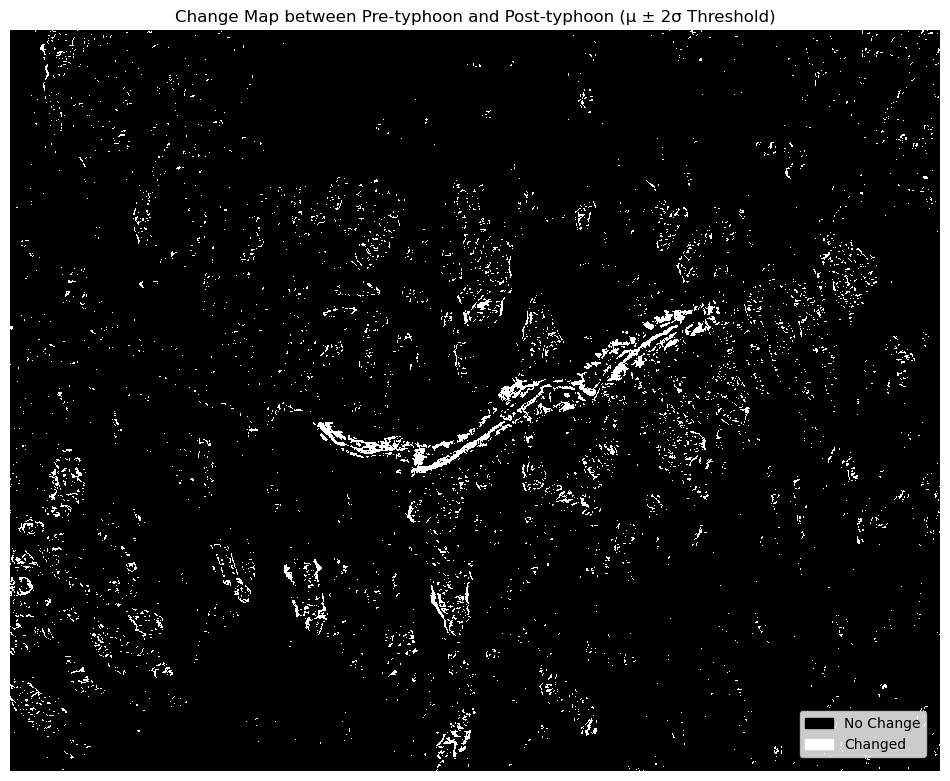

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


# `changed_area` is binary change map data, where "changed" is 1 and "no change" is 0.

fig, ax = plt.subplots(figsize=(12, 12))

# グレーのカラーマップを使って結果をプロットする。
ax.imshow(changed_area, cmap=ListedColormap(['black', 'white']))
ax.set_title("Change Map between Pre-typhoon and Post-typhoon (μ ± 2σ Threshold)")
ax.axis("off")

# 変更なし」と「変更あり」の色を持つカスタム凡例を作成する。
no_change_patch = mpatches.Patch(color="black", label="No Change")  # 黒は変化なし
changed_patch = mpatches.Patch(color="white", label="Changed")      # 変更された白
plt.legend(handles=[no_change_patch, changed_patch], loc="lower right", borderaxespad=1)

# プロットを表示する
plt.show()

ダムの湛水による水域変化が「変化あり」として検出されました。

ダムだけでなく周辺にも「変化あり」とされる画素が点在していますが、これはノイズです。合成開口レーダーはレーダーの入射角（地形の斜面角度と衛星の高度角の差）が観測値に影響するため、その影響を補正する前処理が必要な場合があります。[ALOS-2/PALSAR-2データプロダクトL2.2では斜面勾配補正処理がなされますが、ScanSARに対してのみ処理、無償公開されており](https://www.eorc.jaxa.jp/ALOS/en/dataset/palsar2_l22_e.htm)、標準プロダクトは未提供とのことです。

あらかじめ関心領域を定義しておくことで上記のようなノイズを除外することも重要です。例えば、完全に湛水した状態の水面の形状をあらかじめGISのポリゴンレイヤとして保管しておき、そのポリゴンの内側だけ変化検出の解析を処理するといった工夫が考えられます。あるいは、隣接する画素をクラスターとして、一定サイズ以下のクラスターをノイズとみなす、といった手順も有用と思われます。

### 2.3.4. （参考）Sentinel-2光学衛星画像と比較する。

#### サンプル地点1

**台風前の画像（観測日：2019年10月11日）と台風後の画像（観測日：2019年11月03日）の違い**

![Changed-area1](img_Diff_Pre-Post.PNG)

| ALOS-2 image (filtered image) | Sentinel-2 image |
|-------------------------------|------------------|
| 台風前（観測日：2019年10月11日） | 台風前（観測日：2019年10月10日～11日） |
| ![ALOS-2_pre1](validate-pre1.png) | ![Sentinel-2_pre1](sentinel2-pre1.png) |
| 台風後（観測日：2019年11月3日） | 台風後（観測日：2019年10月28日～11月03日） |
| ![ALOS-2_post1](validate-post1.png) | ![Sentinel-2_post1](sentinel2-post1.png) |

#### サンプル地点2

**台風前の画像（観測日：2019年10月11日）と台風後の画像（観測日：2019年11月03日）の違い**。

![Changed-area2](img_Diff_Pre-Post2.PNG)

| ALOS-2 image (filtered image) | Sentinel-2 image |
|-------------------------------|------------------|
| 台風前（観測日：2019年10月11日） | 台風前（観測日：2019年10月10日～11日） |
| ![ALOS-2_pre2](validate-pre2.png) | ![Sentinel-2_pre2](sentinel2-pre2.png) |
| 台風後（観測日：2019年11月3日） | 台風後（観測日：2019年10月28日～11月03日） |
| ![ALOS-2_post2](validate-post2.png) | ![Sentinel-2_post2](sentinel2-post2.png) |

## 2.4 本演習手順の利点と利用方法

### 遠隔地の監視や調査

- 八ッ場ダムのような遠隔地におけるインフラ監視における利用のヒントになります。IoTと衛星通信が充実した近年には、センサの設置だけでも十分かもしれません。しかし、隈無くセンサを設置するには多大な費用がかかる場合には、衛星データとの組み合わせが効果的になります。
- はじめてインフラを開発するような土地には、そもそもセンサの設置計画に必要な情報さえありません。そのような場合には衛星データで**大雑把でも**動態を分析できることは計悪に必要な調査費用を低減することに貢献します。